In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = "/content/drive/MyDrive/Flower Classification/Train"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import numpy as np
import seaborn as sns

from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
dropout_rate = 0.2

In [ ]:
# Initialize a variable to store the total number of images
total_images = 0

# Iterate over the directory and its subdirectories
for root, dirs, files in os.walk(data_dir):
    # Count the number of files in each directory
    num_files = len(files)
    # Add the number of files to the total_images variable
    total_images += num_files

# Print the total number of images
print("Total number of images:", total_images)

Total number of images: 4312


In [ ]:
# Count images per class
classes = os.listdir(data_dir)
images_per_class = {}
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        images_per_class[class_name] = len(os.listdir(class_path))
print("Total number of images per classes:", images_per_class)

Total number of images per classes: {'daisy': 763, 'dandelion': 1051, 'sunflower': 732, 'tulip': 983, 'rose': 783}


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="training",
    seed=100,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
)

Found 4312 files belonging to 5 classes.
Using 3881 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=100,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 4312 files belonging to 5 classes.
Using 1293 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


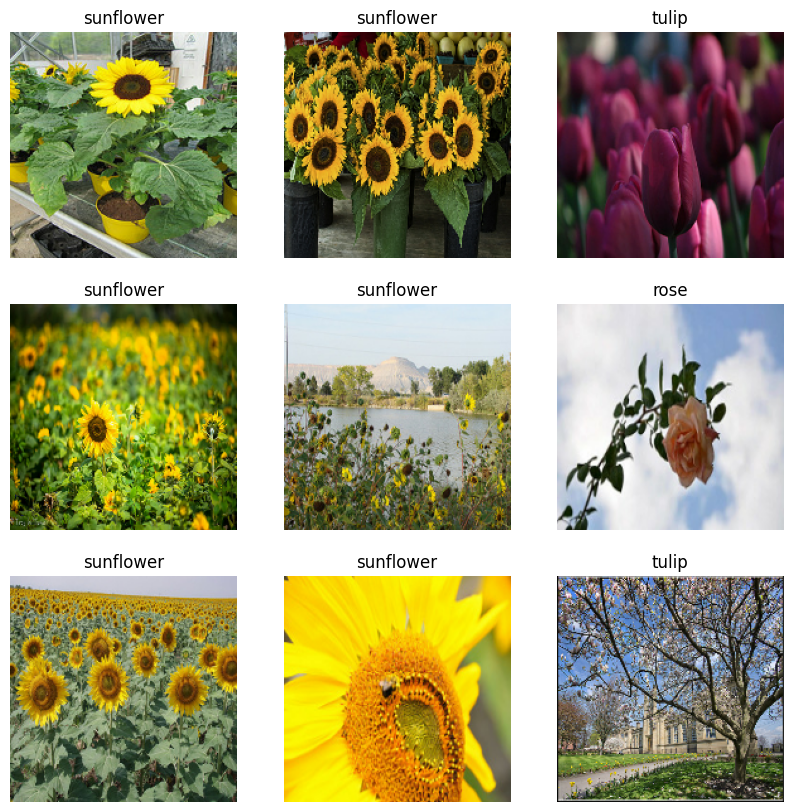

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Data augmentation

In [ ]:
def apply_data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Random rotation
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.2)
    return image, label

# Apply data augmentation to the training dataset
augmented_train_ds = train_ds.map(lambda x, y: apply_data_augmentation(x, y))

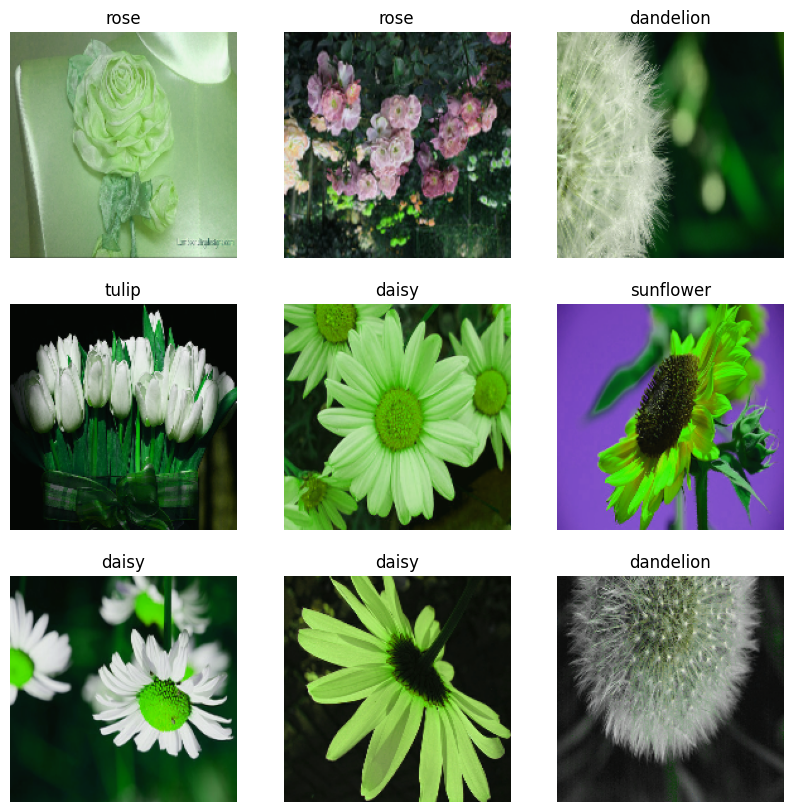

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in augmented_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in augmented_train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
def generate_model(image_height, image_width, nchannels, num_classes):
  model = tf.keras.Sequential([
      layers.Rescaling(1./255, input_shape=(image_height, image_width, nchannels)),

      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
      #layers.BatchNormalization(),
      layers.MaxPooling2D(pool_size=(2, 2), strides=2),

      layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1),
      #layers.BatchNormalization(),
      layers.MaxPooling2D(pool_size=(2, 2), strides=2),

      layers.Flatten(),
      layers.Dense(128, activation="relu"),
      layers.Dropout(0.5),
      #layers.BatchNormalization(),
      layers.Dense(num_classes, activation="softmax")
  ])

  return model

In [ ]:
num_classes = len(class_names)
model = generate_model(img_height, img_width, 3, num_classes)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 64800)            

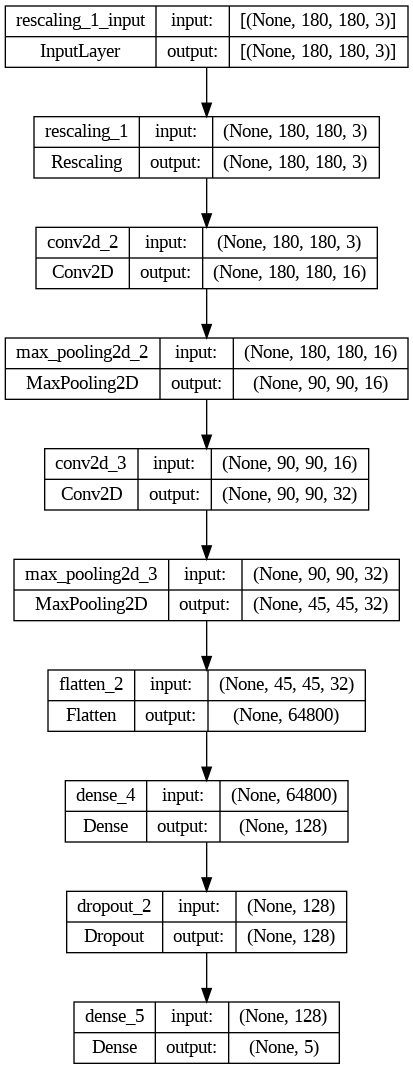

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (usually validation loss)
    patience=10,          # Number of epochs with no improvement
    restore_best_weights=True  # Restore model weights to best epoch
)

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


122/122 [==============================] - 182s 1s/step - loss: 1.4613 - accuracy: 0.4192 - val_loss: 1.0390 - val_accuracy: 0.6218
Epoch 2/10
122/122 [==============================] - 166s 1s/step - loss: 1.1214 - accuracy: 0.5496 - val_loss: 0.8784 - val_accuracy: 0.6837
Epoch 3/10
122/122 [==============================] - 162s 1s/step - loss: 0.9323 - accuracy: 0.6491 - val_loss: 0.7643 - val_accuracy: 0.7363
Epoch 4/10
122/122 [==============================] - 166s 1s/step - loss: 0.7388 - accuracy: 0.7078 - val_loss: 0.5689 - val_accuracy: 0.8144
Epoch 5/10
122/122 [==============================] - 165s 1s/step - loss: 0.5622 - accuracy: 0.7972 - val_loss: 0.4720 - val_accuracy: 0.8476
Epoch 6/10
122/122 [==============================] - 186s 2s/step - loss: 0.4386 - accuracy: 0.8408 - val_loss: 0.4402 - val_accuracy: 0.8585
Epoch 7/10
122/122 [==============================] - 168s 1s/step - loss: 0.3221 - accuracy: 0.8856 - val_loss: 0.4208 - val_accuracy: 0.8685
Epoch 8/10

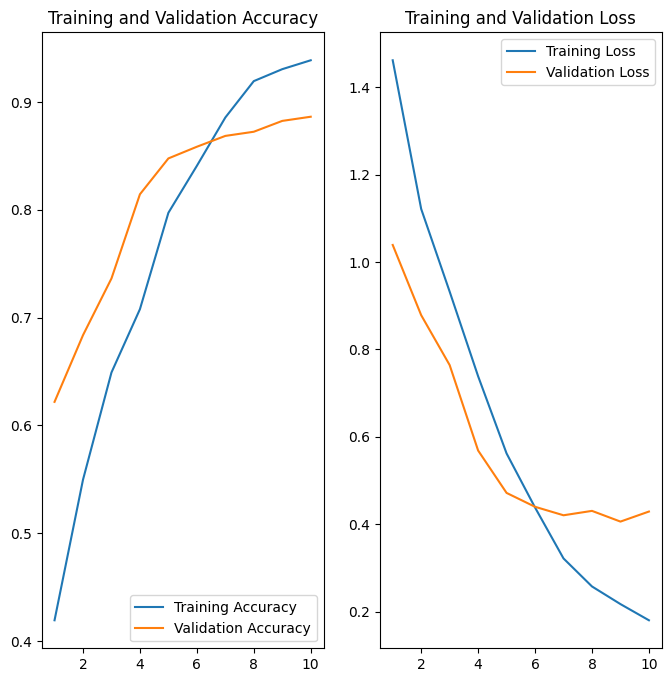

In [ ]:
def plot_acc_and_loss():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)

    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)

    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_acc_and_loss()

In [ ]:
def calculate_acc_and_loss(model):
    test_loss, test_accuracy = model.evaluate(val_ds)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

calculate_acc_and_loss(model)

41/41 [==============================] - 17s 389ms/step - loss: 0.4293 - accuracy: 0.8863
Test Loss: 0.42934706807136536
Test Accuracy: 0.886310875415802


Training ko validation prediction

1/1 [==============================] - 1s 564ms/step


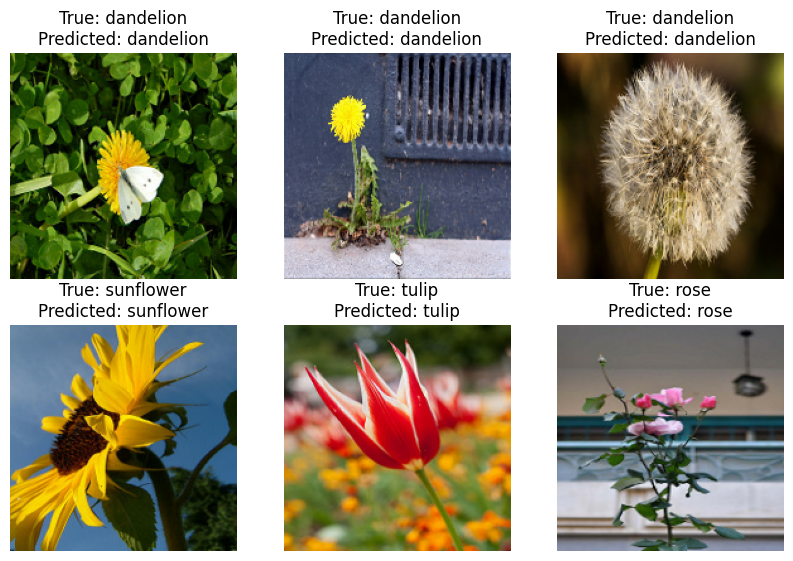

In [ ]:
def predict_and_plot(model, class_names, images, labels):
    predictions = model.predict(images)
    plt.figure(figsize=(10, 10))
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_label = class_names[np.argmax(predictions[i])]
        true_label = class_names[labels[i]]
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
        plt.axis("off")
    plt.show()
for images, labels in val_ds.take(1):
    predict_and_plot(model, class_names, images, labels)

In [ ]:
def evaluation_metrices(model):
    test_labels = []
    predictions = []

    for images, labels in val_ds:
        test_labels.extend(labels.numpy())
        predictions.extend(np.argmax(model.predict(images), axis=-1))

    conf_matrix = confusion_matrix(test_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

1/1 [==============================] - 0s 205ms/step


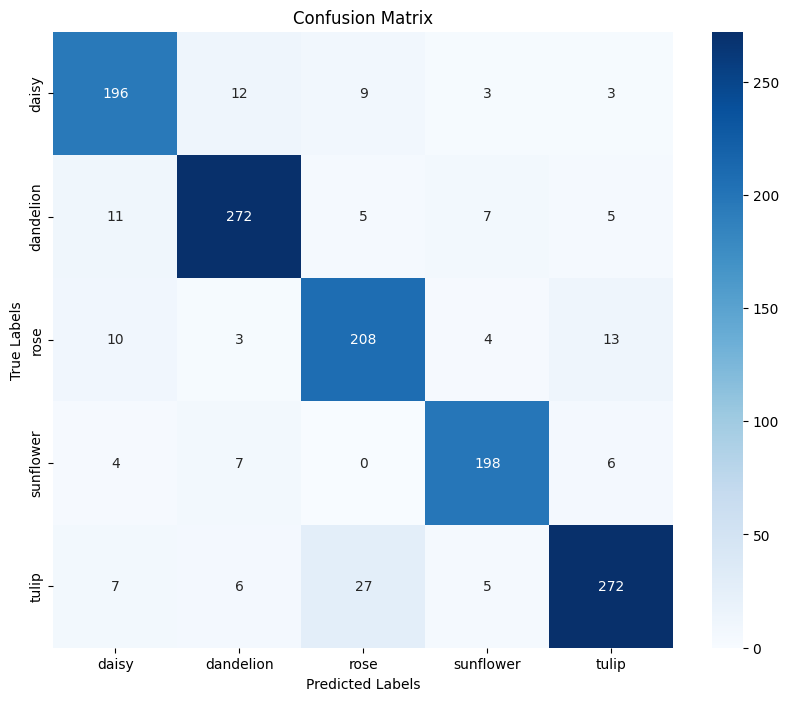

In [ ]:
evaluation_metrices(model)

Test ko prediction

In [ ]:
def predict(url, model):
    img = tf.keras.utils.load_img(
        url, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    plt.imshow(img)
    plt.axis('off')
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

1/1 [==============================] - 0s 44ms/step
This image most likely belongs to sunflower with a 40.46 percent confidence.


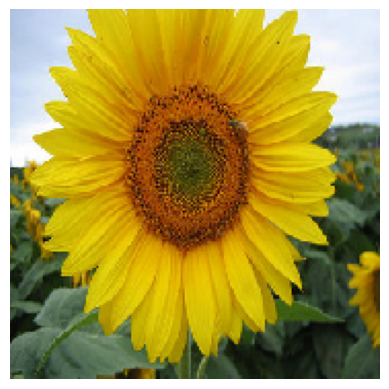

In [ ]:
url1 = "/content/drive/MyDrive/Flower Classification/Test/40410814_fba3837226_n.jpg"
predict(url1, model)

1/1 [==============================] - 0s 50ms/step
This image most likely belongs to rose with a 39.79 percent confidence.


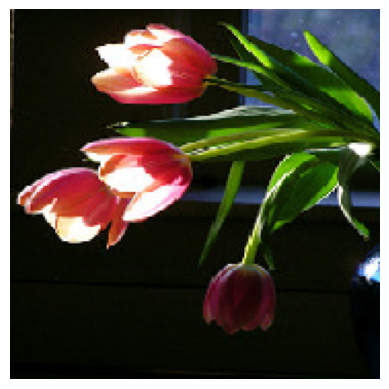

In [ ]:
url2 = "/content/drive/MyDrive/Flower Classification/Test/113960470_38fab8f2fb_m.jpg"
predict(url2,model)

1/1 [==============================] - 0s 38ms/step
This image most likely belongs to daisy with a 40.00 percent confidence.


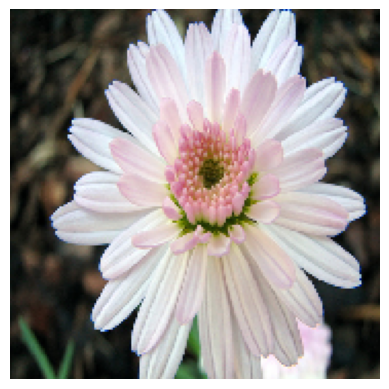

In [ ]:
url3 = "/content/drive/MyDrive/Flower Classification/Test/153210866_03cc9f2f36.jpg"
predict(url3,model)

1/1 [==============================] - 0s 42ms/step
This image most likely belongs to dandelion with a 28.58 percent confidence.


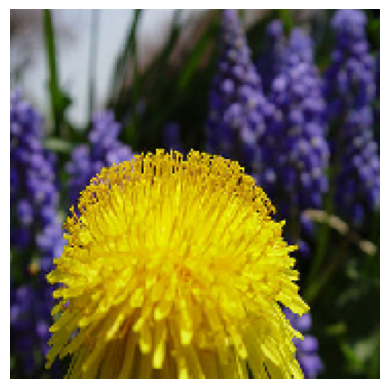

In [ ]:
url4 = "/content/drive/MyDrive/Flower Classification/Test/16159487_3a6615a565_n.jpg"
predict(url4,model)

1/1 [==============================] - 0s 38ms/step
This image most likely belongs to rose with a 38.70 percent confidence.


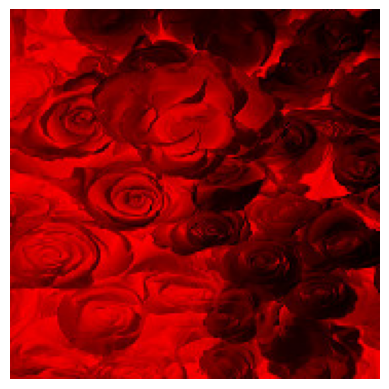

In [ ]:
url5 = "/content/drive/MyDrive/Flower Classification/Test/110472418_87b6a3aa98_m.jpg"
predict(url5,model)

Transfer learning

In [ ]:
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=5)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=5)))

In [ ]:
# Create a Sequential model
resnet_model = Sequential()

# Load the pre-trained ResNet50 model
pretrained_model = ResNet50(include_top=False,
                            input_shape=(180, 180, 3),
                            pooling='avg',
                            classes=5,
                            weights='imagenet')

# Freeze the weights of the pre-trained layers
for layer in pretrained_model.layers:
    layer.trainable = False

# Add the pre-trained model to the Sequential model
resnet_model.add(pretrained_model)

# Add additional layers
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dropout(0.5))
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(5, activation='softmax'))

In [ ]:
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 5)                 2565      
                                                      

In [ ]:
resnet_model.compile(
    optimizer=Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
epochs=10
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/10
122/122 [==============================] - 745s 6s/step - loss: 0.6500 - accuracy: 0.7673 - val_loss: 0.3776 - val_accuracy: 0.8701
Epoch 2/10
122/122 [==============================] - 737s 6s/step - loss: 0.4141 - accuracy: 0.8513 - val_loss: 0.2940 - val_accuracy: 0.9026
Epoch 3/10
122/122 [==============================] - 725s 6s/step - loss: 0.3411 - accuracy: 0.8838 - val_loss: 0.2769 - val_accuracy: 0.9087
Epoch 4/10
122/122 [==============================] - 714s 6s/step - loss: 0.3095 - accuracy: 0.8895 - val_loss: 0.2679 - val_accuracy: 0.9142
Epoch 5/10
122/122 [==============================] - 738s 6s/step - loss: 0.2935 - accuracy: 0.8982 - val_loss: 0.2352 - val_accuracy: 0.9242
Epoch 6/10
122/122 [==============================] - 744s 6s/step - loss: 0.2510 - accuracy: 0.9170 - val_loss: 0.2407 - val_accuracy: 0.9219
Epoch 7/10
122/122 [==============================] - 738s 6s/step - loss: 0.2307 - accuracy: 0.9219 - val_loss: 0.2115 - val_accuracy: 0.9374

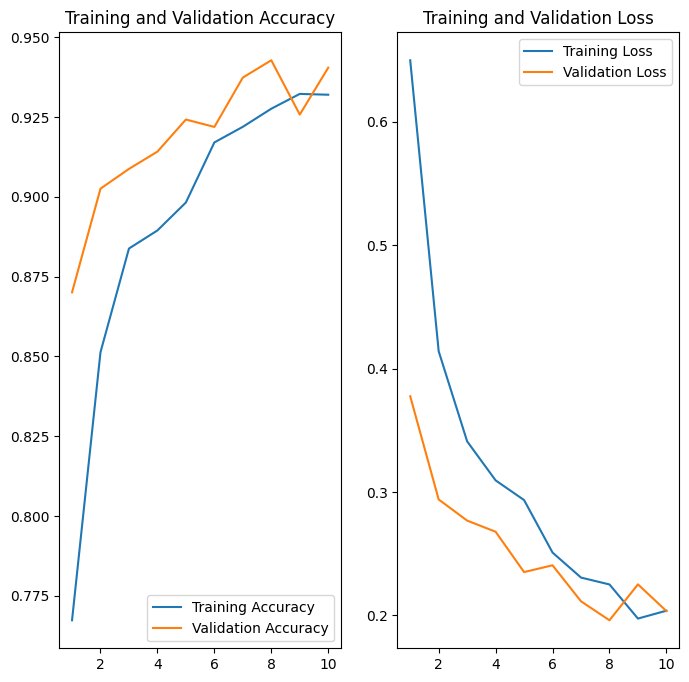

In [ ]:
plot_acc_and_loss()

In [ ]:
calculate_acc_and_loss(resnet_model)

41/41 [==============================] - 211s 5s/step - loss: 0.2036 - accuracy: 0.9404
Test Loss: 0.20356832444667816
Test Accuracy: 0.9404485821723938


1/1 [==============================] - 3s 3s/step
This image most likely belongs to sunflower with a 40.43 percent confidence.


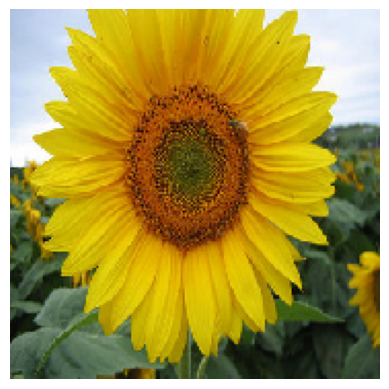

In [ ]:
predict(url1, resnet_model)

1/1 [==============================] - 0s 159ms/step
This image most likely belongs to tulip with a 37.34 percent confidence.


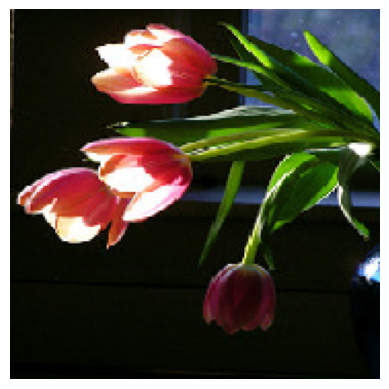

In [ ]:
predict(url2, resnet_model)

1/1 [==============================] - 0s 251ms/step
This image most likely belongs to daisy with a 39.67 percent confidence.


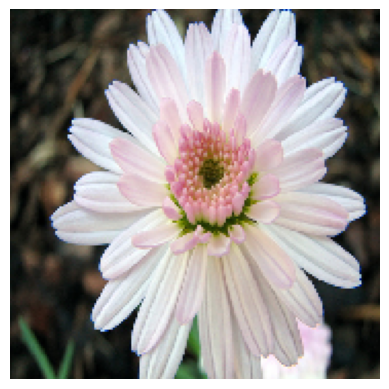

In [ ]:
predict(url3, resnet_model)

1/1 [==============================] - 0s 277ms/step
This image most likely belongs to dandelion with a 39.00 percent confidence.


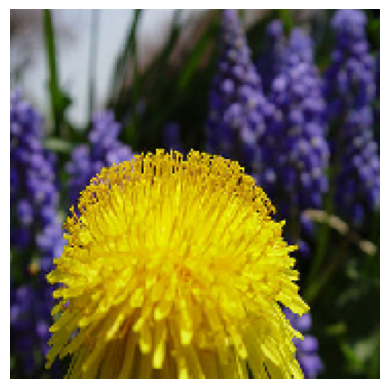

In [ ]:
predict(url4, resnet_model)

1/1 [==============================] - 0s 313ms/step
This image most likely belongs to tulip with a 28.83 percent confidence.


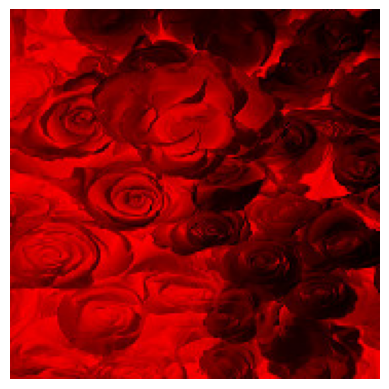

In [ ]:
predict(url5, resnet_model)